# 讀取圖像數據並準備數據

In [4]:
dataset_path = './dataset'

# 載入所需套件

In [5]:
%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import torchvision.models as models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import shuffle, resample
import numpy as np
import matplotlib.pyplot as plt
from miniflow import *
from tqdm.auto import tqdm

# 評估指標

# 訓練和評估模型


In [6]:
def top_1_acc(y_true, y_pred):
    """
    計算 top 1 accuracy
    
    參數:
    y_true -- 真實標籤 (numpy array= m x 1)
    y_pred -- 模型預測機率 (numpy array= m x n)
    k -- 前 k 高的機率會被考慮 (int)
    m -- 樣本個數
    n -- 標籤數量
    
    回傳:
    accuracy -- top k accuracy (float)
    """
    sorted_indices = np.flip(np.argsort(y_pred,axis=1),axis=1) # Descent sorting
    pred_top1 = sorted_indices[:,0]
    accuracy = np.mean(y_true==pred_top1)
    
    return accuracy

def top_5_acc(y_true, y_pred):
    """
    計算 top 1 accuracy
    
    參數:
    y_true -- 真實標籤 (numpy array= m x 1)
    y_pred -- 模型預測機率 (numpy array= m x n)
    k -- 前 k 高的機率會被考慮 (int)
    m -- 樣本個數
    n -- 標籤數量
    
    回傳:
    accuracy -- top k accuracy (float)
    """
    k=2
    sorted_indices = np.flip(np.argsort(y_pred,axis=1),axis=1) # Descent sorting
    pred_top5 = sorted_indices[:,:5]
    num_correct = 0
    for i in range(y_true.shape[0]):
        if y_true[i] in pred_top5[i,:]:
            num_correct += 1
    accuracy = num_correct / len(y_true)
    
    return accuracy


# 訓練和評估模型

In [7]:
feature_name_list = ['Resnet50','HoG']

## Features taking

In [9]:
feature_name = feature_name_list[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(feature_name)
print(device)

Resnet50
cuda:0


In [10]:
train_features = np.load(os.path.join(dataset_path,'train_features_'+feature_name+'.npy'))
train_labels = np.load(os.path.join(dataset_path,'train_labels_'+feature_name+'.npy'))
val_features = np.load(os.path.join(dataset_path,'val_features_'+feature_name+'.npy'))
val_labels = np.load(os.path.join(dataset_path,'val_labels_'+feature_name+'.npy'))
test_features = np.load(os.path.join(dataset_path,'test_features_'+feature_name+'.npy'))
test_labels = np.load(os.path.join(dataset_path,'test_labels_'+feature_name+'.npy'))

## Essential functions


In [95]:
#Initialize the layers
def init_layers(nn_architecture, seed = 99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

#Define activation functions
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

#Build the single-layer forward propagation
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(Z_curr), Z_curr

#Build the full-layer forward propagation
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

#Difine loss functions
def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

#Build the single-layer backward propagation
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

#Build the full-layer backward propagation
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    m = Y.shape[1]
    
    Y_hat = np.argmax(Y_hat,axis=0)
    Y_hat = Y_hat.reshape((1,Y_hat.shape[0]))
    
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

#Update the parameters
def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values

#Train the model
def train(X, Y, nn_architecture, epochs, learning_rate):
    params_values = init_layers(nn_architecture, 2)
    cost_history = []
    accuracy_history = []
    
    for i in range(epochs):
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        cost = get_cost_value(Y_hat, Y)
        cost[np.isnan(cost)] = 0
        cost[np.isinf(cost)] = 0
        cost = np.mean(cost)
        # cost = np.sum(cost**2)
        # print(cost)

        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)

        if i % 50 == 0:
            print("Epochs: {} - cost: {:.4f} - accuracy: {:.4f}".format(i, cost, accuracy))
        
    return params_values, cost_history, accuracy_history

## One Layer Perception

/tmp/ipykernel_761411/3562061464.py:70: RuntimeWarning: divide by zero encountered in log
  cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
/tmp/ipykernel_761411/3562061464.py:110: RuntimeWarning: divide by zero encountered in divide
  dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
/tmp/ipykernel_761411/3562061464.py:110: RuntimeWarning: invalid value encountered in divide
  dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));


Epochs: 0 - cost: 64.7483 - accuracy: 0.0000
Epochs: 200 - cost: 0.0000 - accuracy: 0.0000


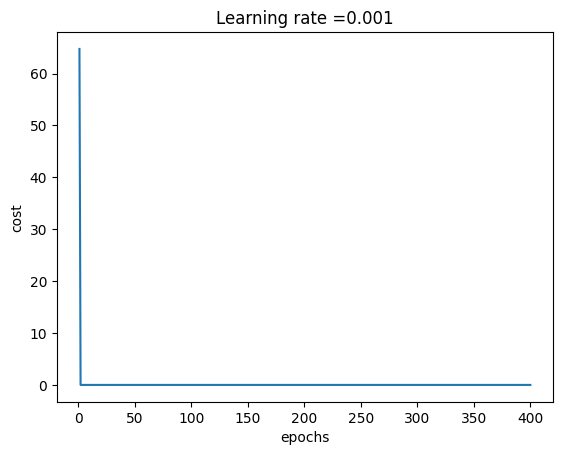

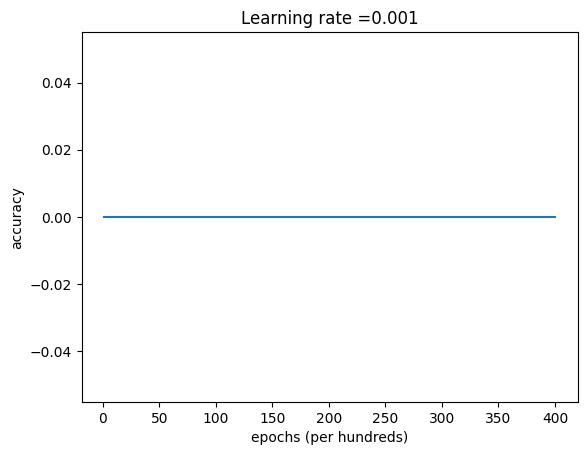

In [93]:
NN_ARCHITECTURE = [
    {"input_dim": 2048, "output_dim": 50, "activation": "sigmoid"},
]
Epochs = 400
Learning_rate = 0.001

# Training
params_values, cost_history, accuracy_history = train(
    np.transpose(train_features), 
    np.transpose(train_labels.reshape((train_labels.shape[0], 1))),
    NN_ARCHITECTURE, Epochs, Learning_rate)

# Plot the cost and accuracy
plt.plot(range(1,Epochs+1),np.array(cost_history), label='Training Loss')
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title("Learning rate =" + str(Learning_rate))
plt.show()

plt.plot(range(1,Epochs+1),accuracy_history, label='Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs (per hundreds)')
plt.title("Learning rate =" + str(Learning_rate))
plt.show()


## Two Layer Perception

Epochs: 0 - cost: -5.2798 - accuracy: 0.0000
Epochs: 50 - cost: 37.5059 - accuracy: 0.0000


/tmp/ipykernel_761411/671457796.py:110: RuntimeWarning: divide by zero encountered in divide
  dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
/tmp/ipykernel_761411/671457796.py:110: RuntimeWarning: invalid value encountered in divide
  dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));


Epochs: 100 - cost: 0.0000 - accuracy: 0.0000
Epochs: 150 - cost: 0.0000 - accuracy: 0.0000
Epochs: 200 - cost: 0.0000 - accuracy: 0.0000
Epochs: 250 - cost: 0.0000 - accuracy: 0.0000
Epochs: 300 - cost: 0.0000 - accuracy: 0.0000
Epochs: 350 - cost: 0.0000 - accuracy: 0.0000


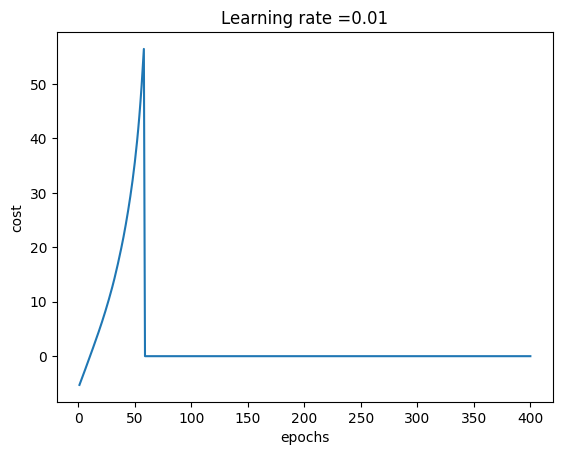

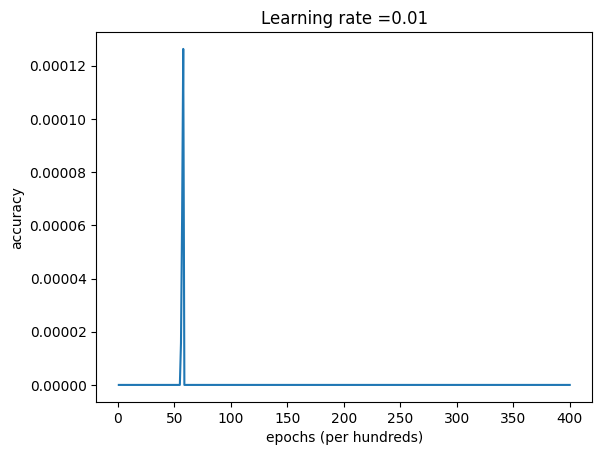

In [96]:
NN_ARCHITECTURE = [
    {"input_dim": 2048, "output_dim": 1024, "activation": "sigmoid"},
    {"input_dim": 1024, "output_dim": 50, "activation": "sigmoid"},
]
Epochs = 400
Learning_rate = 0.01

# Training
params_values, cost_history, accuracy_history = train(
    np.transpose(train_features), 
    np.transpose(train_labels.reshape((train_labels.shape[0], 1))),
    NN_ARCHITECTURE, Epochs, Learning_rate)

# Plot the cost and accuracy
plt.plot(range(1,Epochs+1),np.array(cost_history), label='Training Loss')
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title("Learning rate =" + str(Learning_rate))
plt.show()

plt.plot(range(1,Epochs+1),accuracy_history, label='Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs (per hundreds)')
plt.title("Learning rate =" + str(Learning_rate))
plt.show()

## LeNet5

![image.png](attachment:cb574f9a-24f1-4715-a236-cf9fc004094b.png)

## Improved LeNet5

* Activation function: x = Sigmoid(x) ==> x = x*sigmoid(x)
* Kernel size: 5x5 ==> 3x3
* Increase one convolution layer to LeNet5 (any position).